# Build an efficient supervised word translator for English to French and French to English

Based on : "Exploiting Similarities among Languages for Machine Translation" of Tomas Mikolov, Quoc V. Le & Ilya Sutskever (2013)

In [1]:
import io

import numpy as np
from numpy import dot
from numpy.linalg import norm

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

In [2]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
eng_path = '/Users/louismonier/Downloads/Monolingual/wiki.en.vec' 
fr_path = '/Users/louismonier/Downloads/Monolingual/wiki.fr.vec'
nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

### FRENCH to ENGLISH translation

* source language = french
* target language = english

In [4]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [5]:
# train & test bilingual dictionaries
path_train = r'/Users/louismonier/Downloads/Monolingual/fr-en.0-5000.txt' 
path_test = r'/Users/louismonier/Downloads/Monolingual/fr-en.5000-6500.txt'
dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test) 

### Build a learning a linear mapping from a source (french) to a target (english) embedding space thanks to a translation Matrix W 

Suppose we are given a set of word pairs and their associated vector representations ${ \{x_i , z_i\} }^{n}_{i=1}$ , where $x_i$ ∈ $R^{d1}$ is the distributed representation of word i in the source language, and $z_i$ ∈ $R^{d2}$ is the vector representation of its translation.

It is our goal to find a transformation matrix W such that W xi approximates $z_i$ . In practice, W can be learned by the following optimization problem :

$$ \underset{W}{min} C (W) = \underset{W}{min} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

which we solve with gradient descent (GD), stochastic gradient descent (SGD) or mini-batch gradient descent (BGD).

In [22]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")

print("d1 dimension :", X_train.shape[1])
print("d2 dimension :", X_test.shape[1])

4971 training samples
1483 test samples
d1 dimension : 300
d2 dimension : 300


In [73]:
# function to minimize
def C(W,X,Z):
    S = 0
    S = sum(np.linalg.norm(np.dot(X, W.T) - Z, axis=1)**2)
    return S

In [74]:
# gradient of the function to minimize
def GradW(W,X,Z):
    G = np.zeros((Z_train.shape[1], X_train.shape[1]))
    G = 2*np.dot(X.T, (np.dot(X, W.T) - Z)).T
    return G

In [75]:
# GD function
def GradientDescent(eta, niter): 
    W = np.random.rand(300,300) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter): 
        value_C[t] = C(W,X_train,Z_train)
        W -= eta*GradW(W,X_train,Z_train)
    print("Done...")
    return (W, value_C) #,acc_test,acc_train)

In [76]:
# SGC or BGD
def StochasticGradientDescent(eta, niter, nb):
    W = np.random.rand(300,300) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = np.zeros(niter)
    
    for t in range(niter):
        if nb>1 : # BGD
            l = np.random.choice(len(dico_train), nb) # size of batch
            for p in l : # ok
                grad += (2*np.outer((np.dot(W, X_train[p]) - Z_train[p]), X_train[p]))
        else : # SGD
            l = np.random.randint(low=0,high=len(dico_train)) 
            grad += (2*np.outer((np.dot(W, X_train[l]) - Z_train[l]), X_train[l]))
        
        grad = (1/nb)*grad
        W -= eta*grad
        value_C[t] = C(W,X_train,Z_train)
    print("Done...")
    return (W, value_C)

### Train the model
The goal is to find the best W to map the source language to the target one.

In [77]:
eta = 5e-5
niter = 100

W_GD, C_GD = GradientDescent(eta, niter) # GD
W_SGD, C_SGD = StochasticGradientDescent(eta, niter, 1) # SGD
W_BGD, C_BsGD = StochasticGradientDescent(eta, niter, 50) # BGD

Done...
Done...
Done...


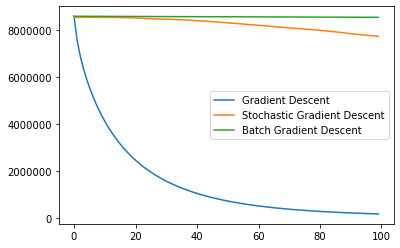

In [83]:
plt.plot(C_GD, label="Gradient Descent")
plt.plot(C_SGD, label="Stochastic Gradient Descent")
plt.plot(C_MGD, label="Batch Gradient Descent")
plt.legend()

WTF pour le SGD et le BGD ? 

In [50]:
Wmin = np.dot(np.linalg.pinv(X_train), Z_train).T 

In [ ]:
d2, d1 = 3, 6
N = 100  # num samples

rng = np.random.RandomState(42)

W = rng.randn(d1, d2)
X = rng.randn(N, d1)
Z_clean = X.dot(W)
print(X.dot(W).shape)

Z = Z_clean + rng.randn(*Z_clean.shape) * .001

#W_est = np.linalg.pinv(X.T).dot(Z.T).T
W_est1 = Z.dot(np.linalg.pinv(X))

In [ ]:
print(W_est.shape)
print(W_est1.shape)

### Testing the model

At the prediction time, for any given new word and its continuous vector representation x, we can map it to the other language space by computing $z = Wx$. Then, we find the word whose representation is closest to z in the target language space, using cosine similarity as the distance metric.

In [ ]:
def prediction(W, new_word):
    x = src_embeddings[src_word2id[new_word]] # vector representation of the new word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred = np.argmax(sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings)) 
    
    return tgt_id2word[z_pred] # return the id of the translated word

In [ ]:
# construct a translation French to English dictionary
def prediction_dict(dico, W):
    dico_pred={}
    i=0
    for word in dico.keys() :
        if (i%10==0):
            print(i)
        dico_pred[word] = prediction(W, word)
        i += 1
    return dico_pred 

In [ ]:
# measure of the accuracy of the dictionnarty
def accuracy(dico_pred, dico):
    c = 0
    for key in dico.keys():
        if dico[key] == dico_pred[key]:
            c += 1
    return(c/len(dico)) # nb de mots bien prédits/nb de mots total

In [ ]:
eta = 0.001
niter = 30
    
W, val, aac_test, acc_train = GradientDescent(eta, niter)

plt.plot(range(len(val)),val)
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()

dico_pred = prediction_dict(dico_test)  
accuracy_test = accuracy(dico_pred,dico_test)

plt.plot(range(0,len(val),10),aac_test)
plt.ylabel('Accuracy TestSet')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## Adressing the inconsistency

Based on "Normalized Word Embedding and Orthogonal Transform for Bilingual Word Translation" of Chao Xing, Dong Wang, Chao Liu & Yiye Lin (2015)

In [ ]:
# function to minimize
def C_ortho(W,X,Z):
    S=0
    for i in range(X.shape[0]):
        S+=(W.dot(X[i])).reshape(1,300).dot(Z[i].reshape(300,1))
    return S

In [ ]:
# gradient of function to minimize
def dC_dW_ortho(W,X,Z):
    S=0
    for i in range(X.shape[0]):
        S+=np.outer(X[i],Z[i])
    return S

In [ ]:
# orthogonal GD function
def orthogonal_GD(alpha,N)
    W = np.random.rand(300,300) # random initialisation of W
    value_C_ortho = []
    
    for t in range(N):
        W += alpha*dC_dW_ortho(tmp_W,X_train,Z_train)
        value_C_ortho.append(C_ortho(W,X_train,Z_train))
        
    #rajouter contrainte d'orthogonalité sur W 
    print(value_C_ortho)
    print(dC_dW_ortho(W,X_train,Z_train))
    print(np.linalg.norm(dC_dW_ortho(W,X_train,Z_train)))
    return(W,value_C_ortho)